In [146]:
# Feature extraction for sound analysis of birdsong
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import scipy.signal as signal

%matplotlib inline

Comparing Distance Metrics: Autocorrelation, Earth Movers Distance, SSIM, DTW

In [160]:
syllables = pd.read_pickle('syllables.pkl')

data = pd.DataFrame()
data['sonogram'] = pd.Series(syllables['sonogram'].values)
data['audio'] = pd.Series(syllables['audio'].values)

data.head()
# Flatten the sonogram to a 1D array
data['sonogram_flat'] = data['sonogram'].apply(lambda x: x.flatten())

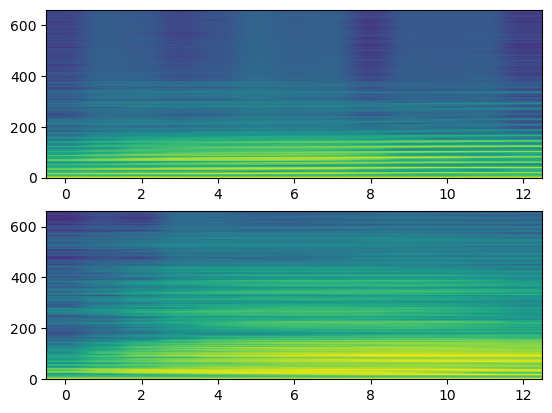

In [150]:
# Sample spectrograms to be compared
def compare_sounds(a,b):
    plt.subplot(2,1,1)
    plt.imshow(np.log(data['sonogram'][a]), aspect='auto', origin='lower')
    plt.subplot(2,1,2)
    plt.imshow(np.log(data['sonogram'][b]), aspect='auto', origin='lower')

compare_sounds(2,1)

In [152]:
from skimage.metrics import structural_similarity
import scipy.stats as stats
import numba

# Method 1: Earths mover distance: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wasserstein_distance.html
def emd(a, b):
    # take the wasserstein distance of each frequency bin, then sum them
    total = 0
    for i in range(len(a)):
        total += stats.wasserstein_distance(a[i], b[i])
        
    return np.log(total)

# Method 2: Dynamic time warping: https://librosa.github.io/librosa/generated/librosa.core.dtw.html
def dtw(a, b):
    D, wp, steps = librosa.sequence.dtw(a, b, metric='canberra', backtrack=True, return_steps=True)
    return np.log(D[wp].sum())

# Method 3: SSIM: https://scikit-image.org/docs/stable/auto_examples/transform/plot_ssim.html
def ssim(a, b):
    return structural_similarity(a, b, 
                                 gaussian_weights=True, 
                                 sigma=1.5, 
                                 use_sample_covariance=False,
                                 data_range=np.max([np.max(a)-np.min(a), 
                                                    np.max(b)-np.min(b)]))

# Method 4 Cross spectral density: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.csd.html#scipy.signal.csd
def csd(a, b): # Done on raw audio signal, not spectrogram
    f, Pxy = signal.csd(a, b, fs=44100)
    return np.sum(np.abs(Pxy))

# Method 5: Cohereance: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.coherence.html#scipy.signal.coherence
def cohere(a, b): # Done on raw audio signal, not spectrogram
    f, Cxy = signal.coherence(a, b, fs=44100)
    return np.sum(np.abs(Cxy))

def canberra(a, b):
    return np.log(np.sum(np.abs(a-b)/(np.abs(a)+np.abs(b))))

In [153]:
# Comparing two spectrograms for similarity
emd_score = emd(data['sonogram'][0], data['sonogram'][1])
print('Earth movers Distance:', emd_score)

dtw_score = dtw(data['sonogram'][0], data['sonogram'][1])
print('Dynamic Time Warping:', dtw_score)

ssim_score = ssim(data['sonogram'][0], data['sonogram'][1])
print('Structural Similarity:', ssim_score)

csd_score = csd(data['audio'][0], data['audio'][1])
print('CSD:', csd_score)

cohere_score = cohere(data['audio'][0], data['audio'][1])
print('Coherence:', cohere_score)

canberra_score = canberra(data['sonogram'][0], data['sonogram'][1])
print('Canberra:', canberra_score)

Earth movers Distance: 23.8520403080753
Dynamic Time Warping: 13.898451277083385
Structural Similarity: 0.8791207910953378
CSD: 30811.771
Coherence: 25.06866
Canberra: 8.23652005901228


In [154]:
# Listen to template audio
from IPython.display import Audio

temp_number = 2
Audio(data['audio'][temp_number], rate=44100)

In [156]:
template_sono = data['sonogram'][temp_number]
template_audio = data['audio'][temp_number]

emd_scores = np.zeros(len(data))
dtw_scores = np.zeros(len(data))
ssim_scores = np.zeros(len(data))
csd_scores = np.zeros(len(data))
cohere_scores = np.zeros(len(data))
canberra_scores = np.zeros(len(data))

for i in range(len(syllables)):
    emd_scores[i] = emd(template_sono, data['sonogram'][i])
    dtw_scores[i] = dtw(template_sono, data['sonogram'][i])
    ssim_scores[i] = ssim(template_sono, data['sonogram'][i])
    csd_scores[i] = csd(template_audio, data['audio'][i])
    cohere_scores[i] = cohere(template_audio, data['audio'][i])
    canberra_scores[i] = canberra(template_sono, data['sonogram'][i])

C:\Users\nriveira\AppData\Local\Temp\ipykernel_13060\1150012202.py:12: RuntimeWarning: divide by zero encountered in log
  return np.log(total)
C:\Users\nriveira\AppData\Local\Temp\ipykernel_13060\1150012202.py:39: RuntimeWarning: divide by zero encountered in log
  return np.log(np.sum(np.abs(a-b)/(np.abs(a)+np.abs(b))))


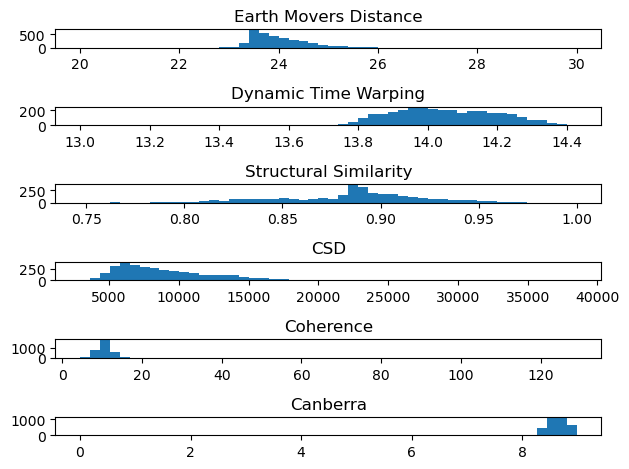

In [157]:
# Plotting the results
emd_scores[emd_scores < 0] = 0
canberra_scores[canberra_scores < 0] = 0

plt.subplot(6,1,1)
plt.hist(emd_scores, 50, [20, 30], label='Earth Movers Distance')
plt.title('Earth Movers Distance')

plt.subplot(6,1,2)
plt.hist(dtw_scores, 50, label='Dynamic Time Warping')
plt.title('Dynamic Time Warping')

plt.subplot(6,1,3)
plt.hist(ssim_scores, 50, label='Structural Similarity')
plt.title('Structural Similarity')

plt.subplot(6,1,4)
plt.hist(csd_scores, 50, label='CSD')
plt.title('CSD')

plt.subplot(6,1,5)
plt.hist(cohere_scores, 50, label='Coherence')
plt.title('Coherence')

plt.subplot(6,1,6)
plt.hist(canberra_scores, 50, label='Canberra')
plt.title('Canberra')
plt.tight_layout()

In [161]:
import numba
spec_shape = data['sonogram'][0].shape
print(spec_shape)

# Pass in the sonograms as 1D arrays, then reshape within the function
# Method 1: Earths mover distance: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wasserstein_distance.html
@numba.njit()
def emd_umap(a, b):
    # take the wasserstein distance of each frequency bin, then sum them
    a = a.reshape(spec_shape)
    b = b.reshape(spec_shape)
    total = 0
    for i in range(len(a)):
        total += stats.wasserstein_distance(a[i], b[i])
        
    return np.log(total)

# Method 2: Dynamic time warping: https://librosa.github.io/librosa/generated/librosa.core.dtw.html
@numba.njit()
def dtw_umap(a, b):
    a = a.reshape(spec_shape)
    b = b.reshape(spec_shape)
    D, wp, steps = librosa.sequence.dtw(a, b, metric='canberra', backtrack=True, return_steps=True)
    return np.log(D[wp].sum())

# Method 3: SSIM: https://scikit-image.org/docs/stable/auto_examples/transform/plot_ssim.html
@numba.njit()
def ssim_umap(a, b):
    a = a.reshape(spec_shape)
    b = b.reshape(spec_shape)
    return structural_similarity(a, b, 
                                 gaussian_weights=True, 
                                 sigma=1.5, 
                                 use_sample_covariance=False,
                                 data_range=np.max([np.max(a)-np.min(a), 
                                                    np.max(b)-np.min(b)]))

# Method 4 Cross spectral density: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.csd.html#scipy.signal.csd
@numba.njit()
def csd_umap(a, b): # Done on raw audio signal, not spectrogram
    f, Pxy = signal.csd(a, b, fs=44100)
    return np.sum(np.abs(Pxy))

# Method 5: Cohereance: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.coherence.html#scipy.signal.coherence
@numba.njit()
def cohere_umap(a, b): # Done on raw audio signal, not spectrogram
    f, Cxy = signal.coherence(a, b, fs=44100)
    return np.sum(np.abs(Cxy))

@numba.njit()
a = a.reshape(spec_shape)
    b = b.reshape(spec_shape)
def canberra_umap(a, b):
    return np.log(np.sum(np.abs(a-b)/(np.abs(a)+np.abs(b))))

(661, 13)


In [159]:
import umap
data_sono = np.array(syllables['sonogram'].tolist())
data_audio = np.array(syllables['audio'].tolist())

def draw_umap(data, n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', title=''):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    u = fit.fit_transform(data);
    fig = plt.figure()
    if n_components == 1:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], range(len(u)), c=data)
    if n_components == 2:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], u[:,1], c=data)
    if n_components == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(u[:,0], u[:,1], u[:,2], c=data, s=100)
    plt.title(title)

draw_umap(data=data_sono, n_neighbors=15, min_dist=0.1, n_components=2, metric=emd_umap, title='UMAP: EMD')

ValueError: Found array with dim 3. None expected <= 2.